# Метрические алгоритмы

## Теоретическое задание

### Задача 1

Может ли в методе $k$ ближайших соседей при $k=4$ получиться лучший результат, чем при
$k=3$? Отказы от классификации тоже считать ошибками.

Да, может. Заметим, что при мультиклассовой классификации четвертый сосед может разрешить неоднозначность. Если три ближайших соседа класса имеют разные классы, то четвертый уменьшает количество ошибок

## Практическое задание

Сгенерируйте и визуализируйте ряд двумерных обучающих выборок (не менее 3), разделенных на два класса и образующих фигуру "пила" (как в примере). Выборки должны быть иметь одинаковое количество объектов, но отличаться высотой и шириной зубцов "пилы". Для каждой выборки :

1) Посчитайте первых 5 профилей компактности.

2) Посчитайте CCV для алгоритма одного ближайшего соседа и длин контрольной выборки от 1 до 5

3) Посчитайте функционал скользящего контроля при разбиении методом KFold.
    Постройте график зависимости величины профиля компактности от номера (То есть зависимость $P(m)$ от $m$).

4) Постройте график зависимости величины CCV для алгоритма одного ближайшего соседа от длины контрольной выборки.

 5) Постройте график зависимости величины CCV от количества рассматриваемых соседей при длине контрольной выборки равной 5.

### Пример

In [2]:
from sklearn import cross_validation, ensemble, grid_search, linear_model, metrics, pipeline, preprocessing
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
def plot_model_data(blue_data, red_data):
    plt.figure(figsize=(10, 10))
    plt.scatter(blue_data[:,0], blue_data[:,1], color="blue", alpha=0.3)
    plt.scatter(red_data[:,0], red_data[:,1], color="red", alpha=0.3)
    plt.show()

In [4]:
def generate_saw(point_count, width, height):
    points = np.random.rand(point_count, 2)
    subsaw_index = (points[:, 0] / width).astype(int)
    unit = points[:, 0] - subsaw_index * width
    below_index = points[:, 1] < 0.5 - 2.0 * (subsaw_index % 2 - 0.5) * (unit * 2 * height / width - height)
    blue_data = points[below_index, :]
    red_data = points[~below_index, :]
    return blue_data, red_data

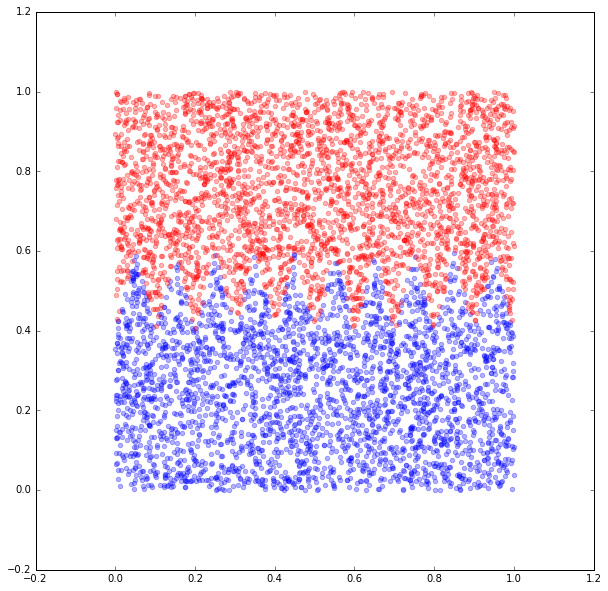

In [5]:
blue_data, red_data = generate_saw(6000, 0.05, 0.1)
plot_model_data(blue_data, red_data)

In [6]:
def compute_mth_neighbour(point, data, m, metric=numpy.linalg.norm):
    ########################################   
    #assumes that data is numerical        #
    #O(n) implementation using np.partition#
    #returns index of mth neighbour        #
    ########################################
    return metric(point - data, axis=1).argsort()[m]   

In [7]:
def compute_mth_neighbours_label_vector(data, labels, m):
    return [labels[i] for i in map(lambda x: compute_mth_neighbour(x, data, m), data)]

In [8]:
#как будет профиль компактности по-английски?
def compute_compact_profile(data, labels, m):
    #########################################
    #input: points - классы для m-го соседа #
    #input: labels - классы для объектов    #
    #output Значение функционала скользящего#
    #контроля                               #
    #########################################
    mth_neighbour_labels = compute_mth_neighbours_label_vector(data, labels, m)
    return np.sum(mth_neighbour_labels != labels)/float(len(data))

In [9]:
from scipy.special import binom

In [10]:
def compute_CCV(data, labels, k):
    res = 0
    L = len(labels)
    l = L - k
    for m in range(1, k + 1):
        summand = (compute_compact_profile(data, labels, m))*binom(L-1-m, l-1)/binom(L-1, l)
        res += summand
    return res

In [11]:
def plot_compact_profiles(data, data_labels, xlen=20):
    plt.figure(figsize=(12, 12))
    x = range(1, xlen + 1)
    y = map(lambda i: compute_compact_profile(data, data_labels, i), x)
    plt.plot(x, y)
    return x, y

In [12]:
def plot_CCV(data, data_labels, xlen=20):
    x = range(1, xlen + 1)
    y = map(lambda i: compute_CCV(data, data_labels, i), x)
    plt.figure(figsize=(12, 12))
    plt.plot(x, y)
    return x, y

In [44]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
def plot_CCV_neighbours(data, data_labels, xlen=5):
    x = range(1, 6)
    y = []
    for i in range(1, 6):
        indices = StratifiedKFold(data_labels, n_folds=1000)
        cv_value = 0
        for train_index, test_index in indices:
            X_train, X_test = data[train_index], data[test_index]
            y_train, y_test = data_labels[train_index], data_labels[test_index]
            estimator = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
            estimator.fit(X_train, y_train)
            cv_value += np.sum(y_test!=estimator.predict(X_test))/float(len(y_test))
        y.append(cv_value/1000)
    plt.figure(figsize=(12,12))
    plt.plot(x, y)
    return x, y

 ### Выборка 1

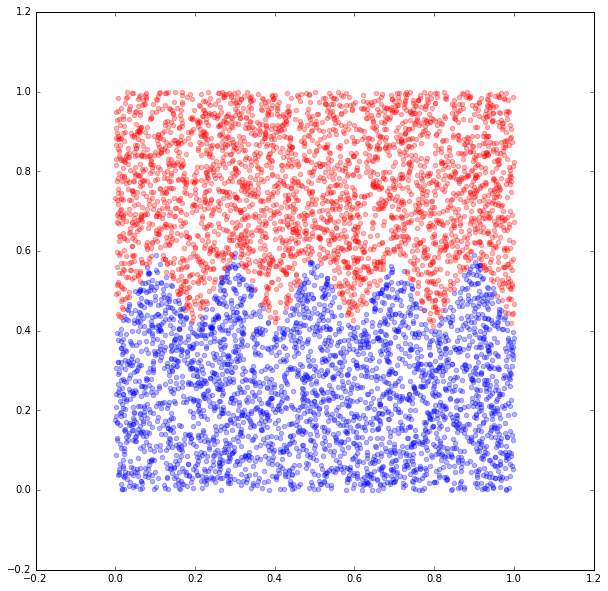

In [13]:
blue_1, red_1 = generate_saw(6000, 0.1, 0.1)
blue_labels = np.zeros(blue_1.shape[0])
red_labels = np.ones(red_1.shape[0])
data_1 = np.vstack([blue_1, red_1])
data_labels_1 = np.concatenate([blue_labels, red_labels])
plot_model_data(blue_1, red_1)

In [14]:
for i in range(1,6):
    print "CCV for validation set of length {0} {1}".format(i, compute_CCV(data_1, data_labels_1, i))

CCV for validation set of length 1 0.00783333333333
CCV for validation set of length 2 0.00783366672223
CCV for validation set of length 3 0.00783400030567
CCV for validation set of length 4 0.00783433408381
CCV for validation set of length 5 0.00783466805679


([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 [0.0078333333333333328,
  0.0098333333333333328,
  0.013333333333333334,
  0.018833333333333334,
  0.020166666666666666,
  0.022499999999999999,
  0.023333333333333334,
  0.029499999999999998,
  0.029000000000000001,
  0.032833333333333332,
  0.030833333333333334,
  0.035000000000000003,
  0.034000000000000002,
  0.033166666666666664,
  0.033666666666666664,
  0.035333333333333335,
  0.033500000000000002,
  0.042833333333333334,
  0.039833333333333332,
  0.038666666666666669])

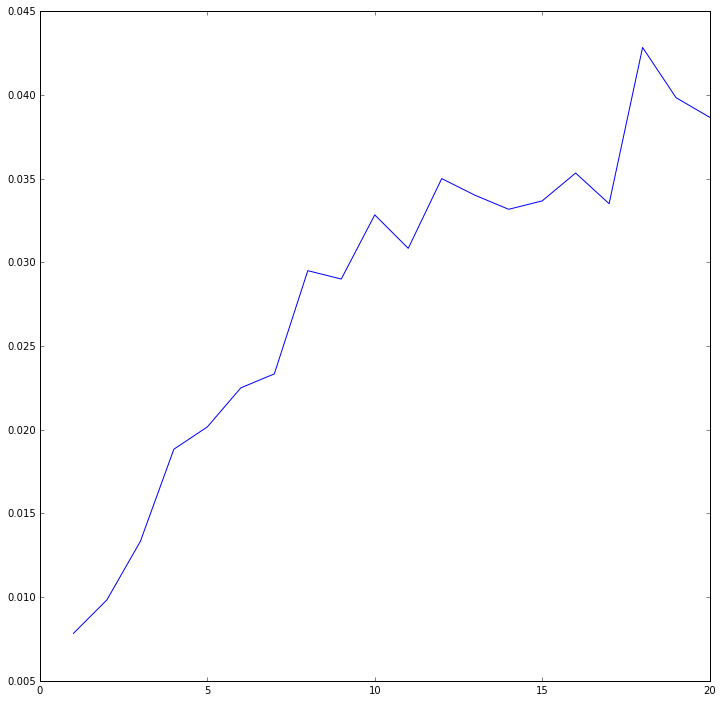

In [15]:
plot_compact_profiles(data_1, data_labels_1)

([1, 2, 3, 4, 5],
 [0.0078333333333333328,
  0.0078336667222314825,
  0.0078340003056713362,
  0.0078343340838058235,
  0.0078346680567879055])

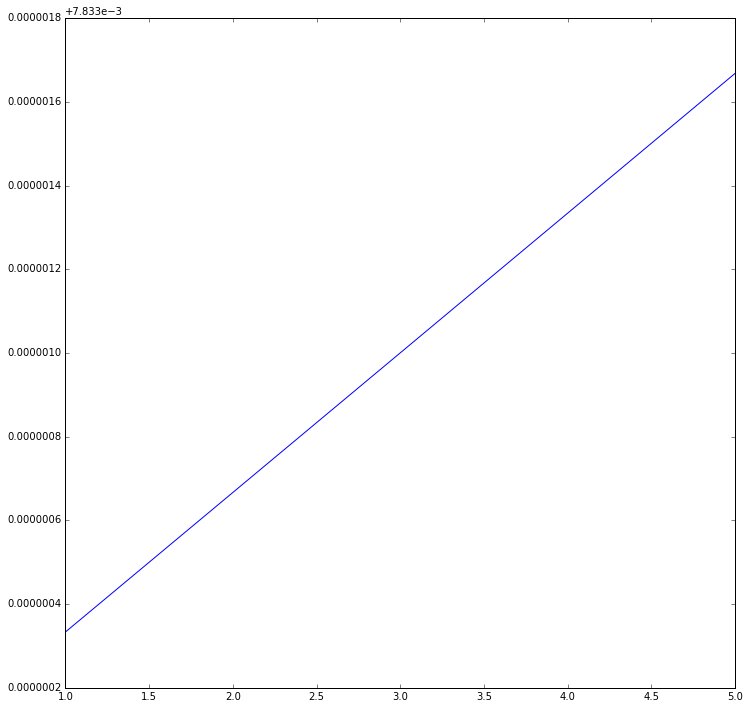

In [17]:
plot_CCV(data_1, data_labels_1, xlen=5)

([1, 2, 3, 4, 5],
 [0.0078095238095238139,
  0.008809523809523814,
  0.0073333333333333375,
  0.010142857142857143,
  0.0088095238095238122])

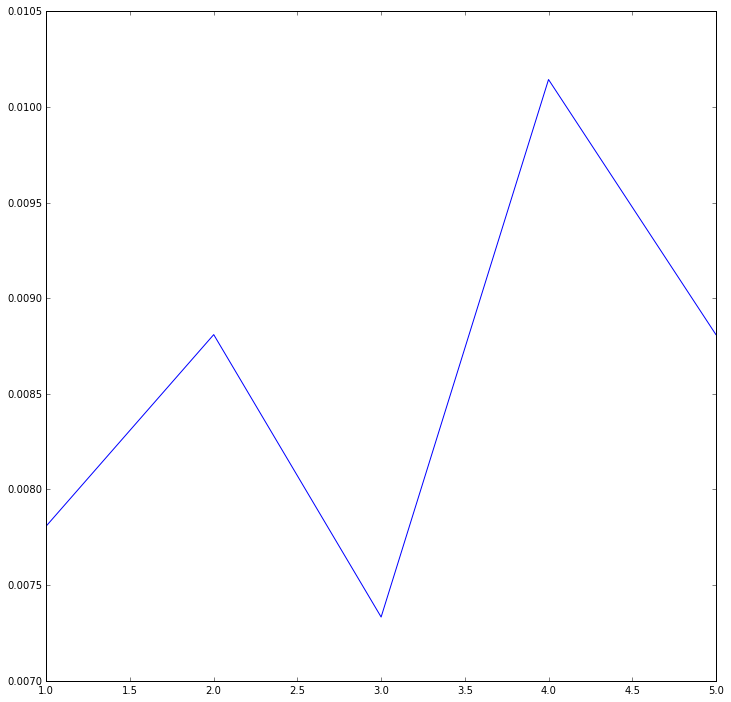

In [45]:
plot_CCV_neighbours(data_1, data_labels_1)

### Выборка 2

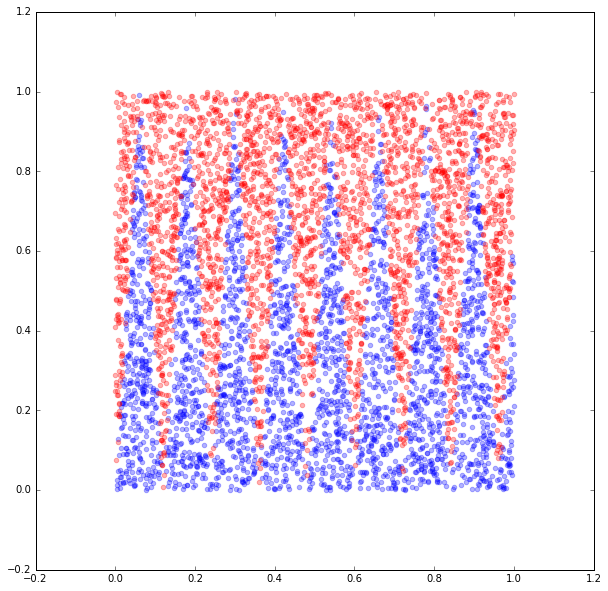

In [18]:
blue_2, red_2 = generate_saw(6000, 0.06, 0.5)
blue_labels = np.zeros(blue_2.shape[0])
red_labels = np.ones(red_2.shape[0])
data_2 = np.vstack([blue_2, red_2])
data_labels_2 = np.concatenate([blue_labels, red_labels])
plot_model_data(blue_2, red_2)

In [19]:
for i in range(1,6):
    print "CCV for validation set of length {0} {1}".format(i, compute_CCV(data_2, data_labels_2, i))

CCV for validation set of length 1 0.0606666666667
CCV for validation set of length 2 0.0606714174585
CCV for validation set of length 3 0.0606761693156
CCV for validation set of length 4 0.0606809222387
CCV for validation set of length 5 0.0606856762285


([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 [0.060666666666666667,
  0.089166666666666672,
  0.10833333333333334,
  0.13133333333333333,
  0.14533333333333334,
  0.16250000000000001,
  0.16533333333333333,
  0.18183333333333335,
  0.19350000000000001,
  0.19616666666666666,
  0.20333333333333334,
  0.21533333333333332,
  0.224,
  0.23233333333333334,
  0.23849999999999999,
  0.24816666666666667,
  0.2485,
  0.25166666666666665,
  0.26666666666666666,
  0.26483333333333331])

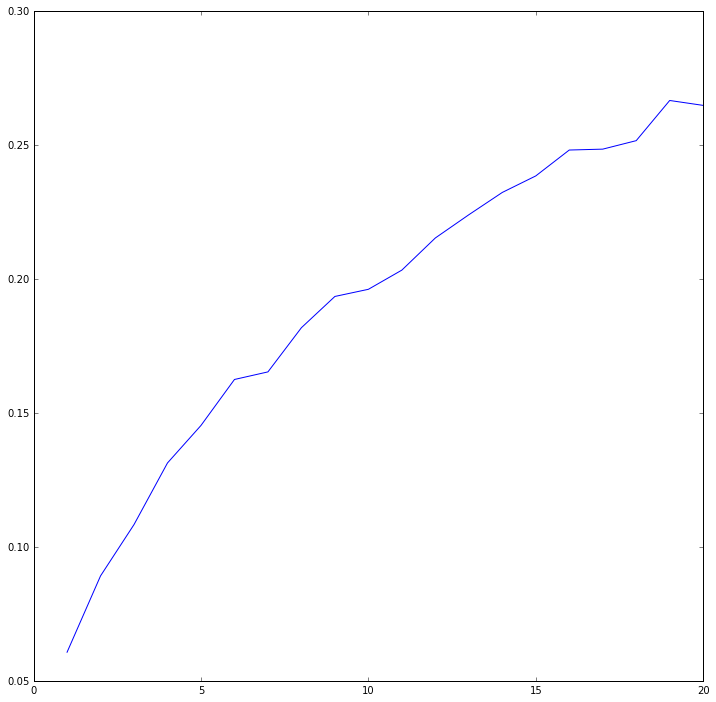

In [20]:
plot_compact_profiles(data_2, data_labels_2)

([1, 2, 3, 4, 5],
 [0.060666666666666667,
  0.060671417458465299,
  0.060676169315611365,
  0.060680922238744391,
  0.060685676228504161])

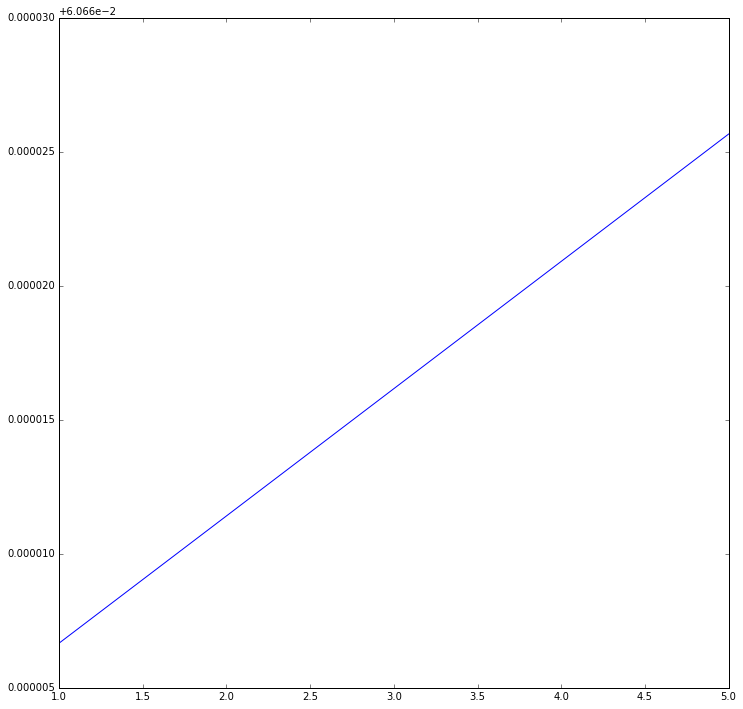

In [21]:
plot_CCV(data_2, data_labels_2, xlen=5)

([1, 2, 3, 4, 5],
 [0.060909523809523775,
  0.072228571428571364,
  0.06722857142857136,
  0.073299999999999935,
  0.067585714285714207])

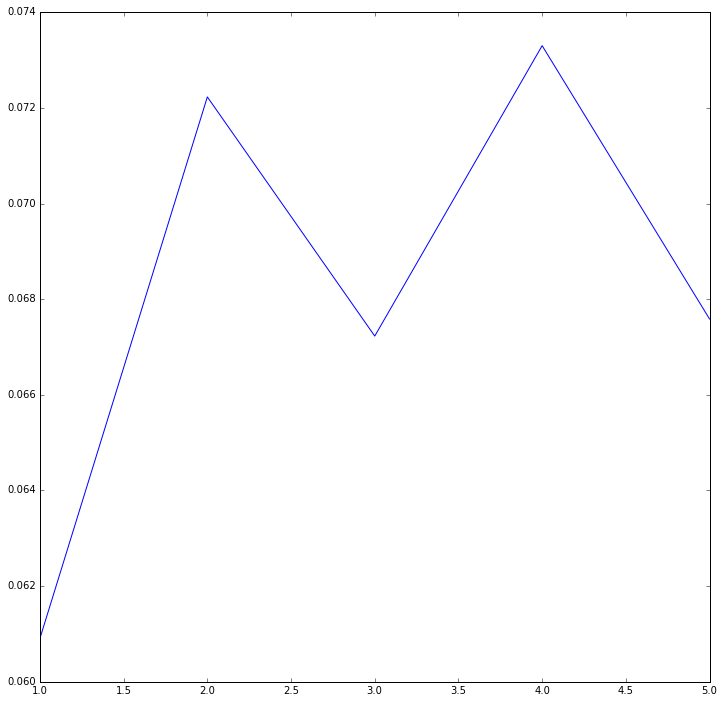

In [46]:
plot_CCV_neighbours(data_2, data_labels_2)

### Выборка 3

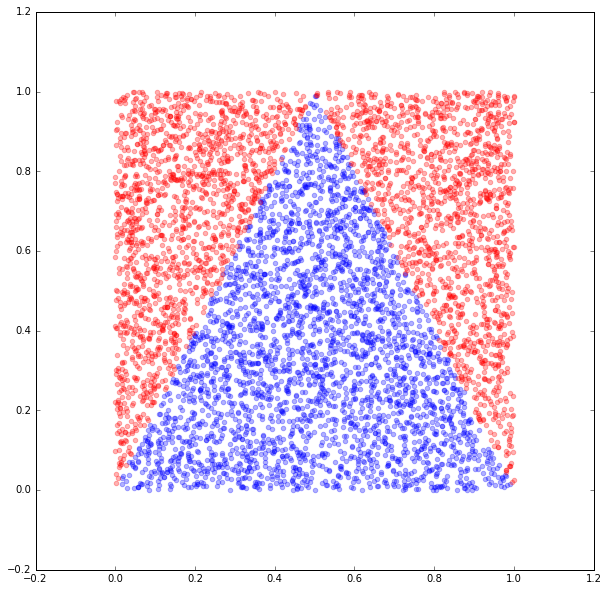

In [24]:
blue_3, red_3 = generate_saw(6000, 0.5, 0.5)
blue_labels = np.zeros(blue_3.shape[0])
red_labels = np.ones(red_3.shape[0])
data_3 = np.vstack([blue_3, red_3])
data_labels_3 = np.concatenate([blue_labels, red_labels])
plot_model_data(blue_3, red_3)

In [25]:
for i in range(1,6):
    print "CCV for validation set of length {0} {1}".format(i, compute_CCV(data_3, data_labels_3, i))

CCV for validation set of length 1 0.008
CCV for validation set of length 2 0.00800125020837
CCV for validation set of length 3 0.00800250050938
CCV for validation set of length 4 0.0080037509031
CCV for validation set of length 5 0.00800500138964


([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 [0.0080000000000000002,
  0.0155,
  0.017166666666666667,
  0.020166666666666666,
  0.020166666666666666,
  0.025166666666666667,
  0.027833333333333335,
  0.030499999999999999,
  0.032000000000000001,
  0.033666666666666664,
  0.037999999999999999,
  0.036666666666666667,
  0.039,
  0.042833333333333334,
  0.039,
  0.049333333333333333,
  0.044999999999999998,
  0.048500000000000001,
  0.047500000000000001,
  0.053166666666666668])

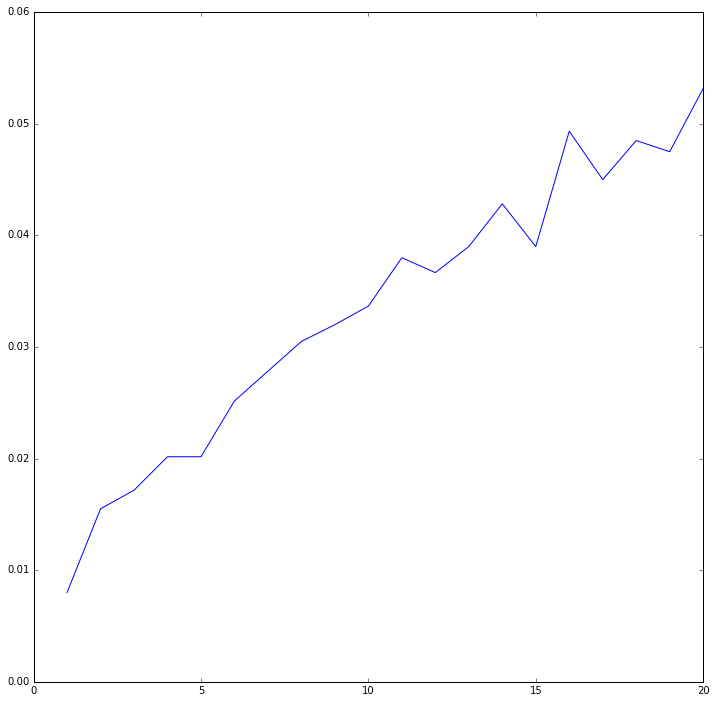

In [26]:
plot_compact_profiles(data_3, data_labels_3)

([1, 2, 3, 4, 5],
 [0.0080000000000000002,
  0.0080012502083680621,
  0.0080025005093750292,
  0.0080037509031043209,
  0.0080050013896393549])

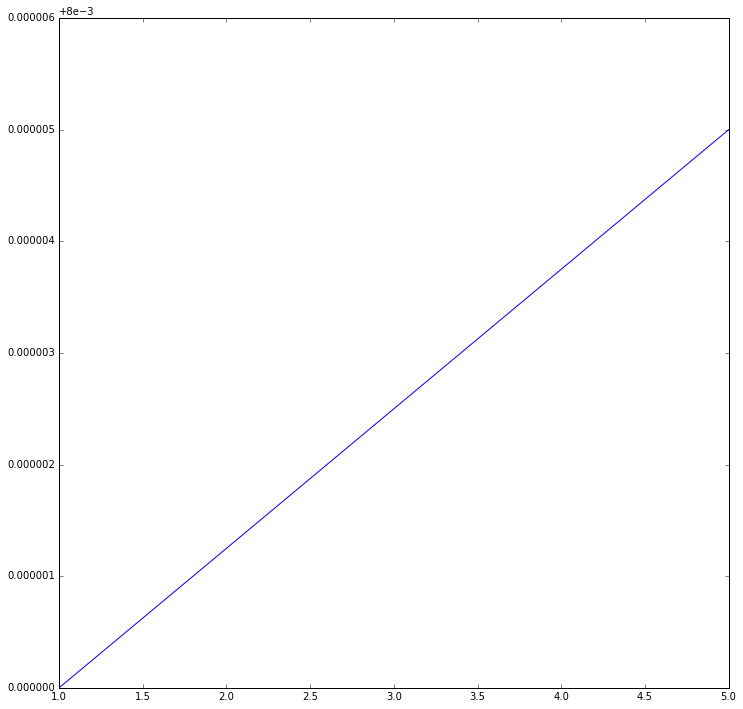

In [47]:
plot_CCV(data_3, data_labels_3, xlen=5)

([1, 2, 3, 4, 5],
 [0.0079761904761904822,
  0.011019047619047616,
  0.011319047619047612,
  0.012485714285714274,
  0.0098619047619047627])

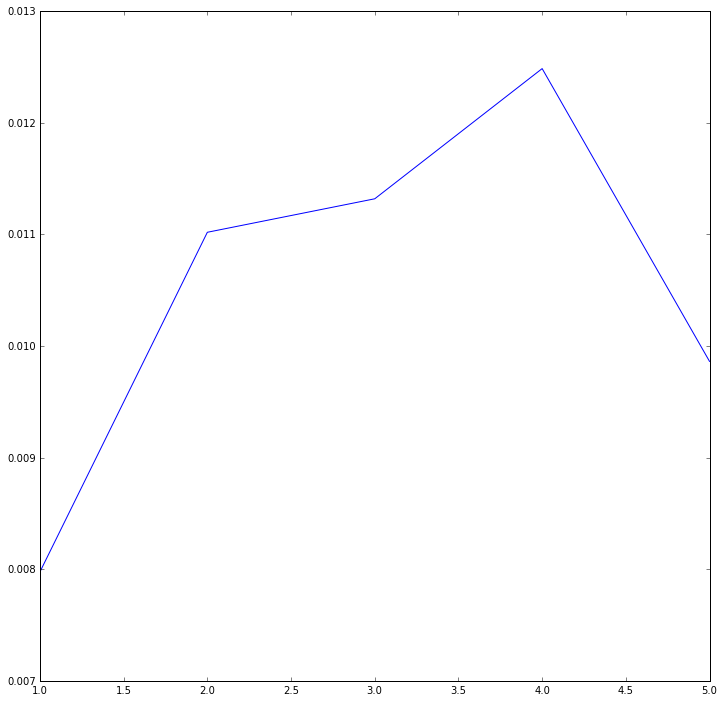

In [48]:
plot_CCV_neighbours(data_3, data_labels_3)

# Линейные алгоритмы

## Теоретическое задание

### Задача 1

Являются ли ядрами:

  a) $K(x,y) = exp(2<x,y>)+<y+x,3y+x>$; 
  
  b) $K(x,y) = ch(<x,y>)$+$3sh(<x,y>)$?

a)Не является ядром так как не является симметричной

b)симметричная и неотрицательно неопределенная - является ядром

### Задача 2

Для какого алгоритма классификации функционал аппроксимированного риска будет при-
нимать большее значение на обучающей выборке: для построенного с регуляризацией или
без нее? Почему?

Функционал аппроксимированного риска на ОБУЧАЮЩЕЙ будет больше для алгоритма с регуляризацей, в связи с тем что регуляризация увеличивает его(и тем самым мешает переобучению)

## Практическое задание

1) Считайте данные из файла bike_sharing_train.csv в pandas.DataFrame

In [250]:
#Задание 1
data = pd.read_csv('bike_sharing_train.csv')

2) Выведите небольную часть получившегося DataFrame на экран, посмотрите на данные

In [255]:
#Задание 2
data.head(n=20)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,1
5,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,1
6,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2
7,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,3
8,2011-01-01 08:00:00,1,0,0,1,9.84,14.395,75,0.0000,8
9,2011-01-01 09:00:00,1,0,0,1,13.12,17.425,76,0.0000,14


Проанализируйте описание данных:

***datetime*** - hourly date + timestamp  

***season*** -  1 = spring, 2 = summer, 3 = fall, 4 = winter 

***holiday*** - whether the day is considered a holiday

***workingday*** - whether the day is neither a weekend nor holiday

***weather*** - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
    
***temp*** - temperature in Celsius

***atemp*** - "feels like" temperature in Celsius

***humidity*** - relative humidity

***windspeed*** - wind speed

***count*** - number of total rentals

3) Разделите данные на обучающую и тестовую выборки. Данные имеют временную приявязку, поэтому их нужно разделить по времени: в тестовую выборку нужно выделить объекты из более позднего временного промежутка, по сравнению с обучающей выборкой. Размер тестовой выборки выеберите самостоятельно.

In [289]:
labels = data['count']
dataset = preprocessing.StandardScaler().fit_transform(data[data.columns.difference(['datetime', 'count'])])

In [291]:
#Задание 3
X_train, X_test, y_train, y_test = cross_validation.train_test_split(dataset, labels, test_size = 0.2, random_state = 42)

In [292]:
from sklearn.linear_model import SGDRegressor, Lasso

In [294]:
SGD = SGDRegressor(loss='squared_loss', penalty='l2')

In [295]:
LassoRegressor = Lasso()

In [296]:
SGD.fit(X_train, y_train)

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False)

In [298]:
SGD.predict(X_test)

array([ 307.69672968,   23.61136083,  180.17499412, ...,  259.08289888,
         26.8357052 ,  204.3519081 ])

In [305]:
metrics.mean_absolute_error(y_test, SGD.predict(X_test))

115.04762127599169

In [306]:
LassoRegressor.fit(X_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [307]:
metrics.mean_absolute_error(y_test, LassoRegressor.predict(X_test))

115.18768825512923

In [314]:
#Задание 5.2 Веса регрессии почти одинаковые для обоих регрессоров за исключвением 5, 6 признаков
print np.argsort(SGD.coef_)
print np.argsort(LassoRegressor.coef_)

[2 1 7 6 5 4 3 0]
[2 1 7 5 6 4 3 0]


4) В наборе данных доступны вещественные, бинарные и категориальные признаки, однако со всеми из них можно работать как с вещественными признаками, давайте будем делать именно так. Согласно пункту 10 из раздела "Анализ и визуализация данных" признаки имеют разный маштаб. Отбмасштабируйте признаки с помощью преобразования preprocessing.StandardScaler. 

5.1) Обучите модели linear_model.SGDRegressor и linear_model.Lasso. Оцените качество модели с помощью метрики MAE (metrics.mean_absolute_error). Сравните качество на обучении и на тесте. 

5.2) Проанализируйте веса регрессии. Какие выводы можно сделать? Какие признаки внесли наибольший вклад в модель?

6) Придумайте и сгенерируйте несколько дополнительных признаков на основе существующего набора данных.

In [402]:
data_modified = data

In [403]:
#Задание 6. Новые фичи: час, день недели
data_modified['weekday'] = pd.to_datetime(data['datetime']).apply(lambda x: x.weekday())
data_modified['hour'] = pd.to_datetime(data['datetime']).apply(lambda x: x.hour)

In [404]:
#Задание 4
labels = data_modified['count']
data_modified = data_modified[data_modified.columns.difference(['datetime', 'count'])]
dataset = preprocessing.StandardScaler().fit_transform(data_modified)

In [577]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(dataset, labels, test_size = 0.2, random_state = 42)

In [341]:
from sklearn.linear_model import SGDRegressor, Lasso

In [342]:
#Задание 5.1
SGD = SGDRegressor(loss='squared_loss', penalty='l2')

In [343]:
LassoRegressor = Lasso()

In [344]:
SGD.fit(X_train, y_train)

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False)

In [345]:
SGD.predict(X_test)

array([ 319.23138749,  -14.22177652,  235.52171539, ...,  281.92085297,
         -0.95919405,  206.63110874])

In [346]:
metrics.mean_absolute_error(y_test, SGD.predict(X_test))

108.68169141235929

In [347]:
LassoRegressor.fit(X_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [348]:
metrics.mean_absolute_error(y_test, LassoRegressor.predict(X_test))

107.77338699618379

In [349]:
#Задание 7
print np.argsort(SGD.coef_)
print np.argsort(LassoRegressor.coef_)

[3 6 1 9 7 8 4 5 0 2]
[3 6 1 7 9 8 5 4 0 2]


In [435]:
binary_data_columns = ['holiday', 'workingday']
binary_data_indices = np.array([(column in binary_data_columns) for column in data_modified.columns])

# Создание индекса для вещественных признаков
numeric_data_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'season', 'weather', 'weekday', 'hour']
numeric_data_indices = np.array([(column in numeric_data_columns) for column in data_modified.columns])

categorical_data_columns = []
categorical_data_indices = np.array([(column in categorical_data_columns) for column in data_modified.columns])

In [28]:
from sklearn.pipeline import make_pipeline, FeatureUnion, Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder

In [49]:
###Пайплайн для задания 8
# Создание индекса для бинарных признаков
def get_estimator(model):
    binary_data_columns = ['holiday', 'workingday']
    binary_data_indices = np.array([(column in binary_data_columns) for column in data_modified.columns], dtype = bool)

    # Создание индекса для вещественных признаков
    numeric_data_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'season', 'weather', 'weekday', 'hour']
    numeric_data_indices = np.array([(column in numeric_data_columns) for column in data_modified.columns], dtype = bool)

    categorical_data_columns = []
    categorical_indices = np.array([(column in categorical_data_columns) for column in data_modified.columns], dtype = bool)

    estimator = Pipeline(steps = [       
        ('feature_processing', FeatureUnion(transformer_list = [        
                #binary
                ('binary_variables_processing', FunctionTransformer(lambda data: data[:, binary_data_indices])), 
                ('categorical_variables_processing',Pipeline(steps = [
                    ('selecting', FunctionTransformer(lambda data: data[:, categorical_data_indices])),
                    ('encoding', OneHotEncoder()) 
                ])), 
                #numeric
                ('numeric_variables_processing', Pipeline(steps = [
                    ('selecting', FunctionTransformer(lambda data: data[:, numeric_data_indices])),
                    ('scaling', StandardScaler())            
                ])),

            ])),
        ('model_fitting', model)
        ]
    )

    return estimator

In [563]:
#Задание 8
model = get_estimator(LassoRegressor)

In [564]:
model.fit(X_train, y_train)

Pipeline(steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('binary_variables_processing', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x7f8974380140>, pass_y=False,
          validate=True)), ('categorical_variables_processing', FunctionTransform...e=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])

In [565]:
metrics.mean_absolute_error(y_test, model.predict(X_test))

107.77368045143018

7) Обучите одну из моделей linear_model.SGDRegressor или linear_model.Lasso на получившемся наборе признаков, не забыв предварительно их отмасштабировать. Изменилось ли качество классификации? С какими весами Ваши признаки вошли в модель? Можно ли сделать вывод о том, что от добавления новых признаков качество модели улучшилось?

8) Теперь давайте по-разному обработаем признаки разного типа. Для того, чтобы удобно работать с набором преобразований данных будем использовать pipeline.Pipeline. Ознакомьтесь с примером ниже: а рамках примера строится piplene из двух шагов: обработка данных и обучение модели. В рамках первого шага сначала обрабатываются бинарные данные (остаются без изменений), а потом -  вещественные признаки (масштабируются). На втором шаге строится модель регрессии.

9) На основе примера выше постройте pipeline, который обрабатывает 3 типа признаков: бинарные, вещественные (делаем масштабирование) и категориальные (обрабатываем данные с помощью метода One Hot Encoding - preprocessing.OneHotEncoder). Обучите получившуюся цепочку и оцените качество.

In [ ]:
# Пример:
# train_data, train_labels - DataFrame с обучающей выборкой и значения целевой функции на обучении
# test_data, test_labels - DataFrame с тестовой выборкой и значения целевой функции на тесте

# Создание индекса для бинарных признаков
binary_data_columns = ['holiday', 'workingday']
binary_data_indices = np.array([(column in binary_data_columns) for column in train_data.columns], dtype = bool)

# Создание индекса для вещественных признаков
numeric_data_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'season', 'weather']
numeric_data_indices = np.array([(column in numeric_data_columns) for column in train_data.columns], dtype = bool)

# Создание модели регресии
model = linear_model.SGDRegressor(random_state = 0)

# Объявление pipline -  цепочки преобразования данных, начиная от обработки данных в зависимости от их типа, и 
# заканчивая обучением модели. 

estimator = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])), 
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
                ('scaling', preprocessing.StandardScaler())            
                        ])),

        ])),
    ('model_fitting', model)
    ]
)

# С цепочкой можно работать как с одиночным преобразованием, в частности вызывать методы fit и predict 
estimator.fit(train_data, train_labels)
metrics.mean_absolute_error(test_labels, estimator.predict(test_data))

10) Сделайте выводы: как обработка признаков повлияла на качество модели?

Ошибка уменьшилась

11) Продолжаем работать с pipeline. Подбрети параметры модели с помощью случайного поиска по сетке.

In [578]:
from sklearn.grid_search import RandomizedSearchCV, GridSearchCV

In [579]:
model = Lasso()

In [580]:
parameters = {
    'alpha':[1, 0.5, 0.1, 0.05, 0.02, 0.01, 0.003],
    'max_iter':[100, 500, 1000, 2000, 3000, 5000, 10000],
    'tol': [0.0001, 0.0002, 0.0003, 0.0005, 0.001],
}

In [581]:
randomcv = RandomizedSearchCV(model, param_distributions=parameters, refit=True)

In [582]:
gridcv = GridSearchCV(model, param_grid=parameters, refit=True)

In [583]:
randomcv.fit(X_train, y_train)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'alpha': [1, 0.5, 0.1, 0.05, 0.02, 0.01, 0.003], 'max_iter': [100, 500, 1000, 2000, 3000, 5000, 10000], 'tol': [0.0001, 0.0002, 0.0003, 0.0005, 0.001]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          scoring=None, verbose=0)

In [584]:
gridcv.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': [1, 0.5, 0.1, 0.05, 0.02, 0.01, 0.003], 'max_iter': [100, 500, 1000, 2000, 3000, 5000, 10000], 'tol': [0.0001, 0.0002, 0.0003, 0.0005, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [585]:
metrics.mean_absolute_error(y_test,cv.predict(X_test))

107.77621445362838

In [586]:
metrics.mean_absolute_error(y_test, gridcv.predict(X_test))

107.77571267747223

12)  Сделайте выводы: как подбор параметров повлиял на качество модели?

Качество улучшилось незначительно

13) Постройте следующий график: отобразите объекты тестовой и обучающей выборок (объекты из обучения и теста должны отображаться разными цветами) в координатах целевая функция/оценка целевой функции с помощью псостроенной модели. 

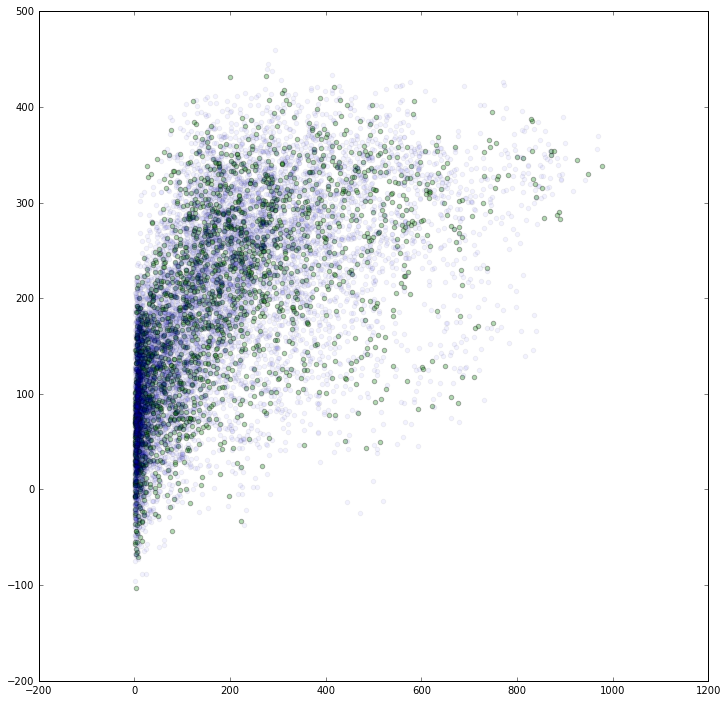

In [654]:
#задание 13
plt.figure(figsize=(12, 12))
plt.scatter(y_test, gridcv.predict(X_test), c = 'green', alpha=.3)
plt.scatter(y_train, gridcv.predict(X_train), c = 'blue', alpha = 0.05)

14) Какие выводы можно сделать на основе построенного графика? Насколько хорошую модель мы получили?

Не очень хорошую. Заметно большое скопление синих объектов в нуле, которые никак не накрываются зелеными.

# Логические алгоритмы

## Теоретическое задание

Пусть $P$,$N$ — число своих и чужих во всей выборке, $P+N=l$. $p$,$n$ — число классифицируемых
своими и чужими закономерностью $R$.

### Задача 1

#### Энтропийный кртерий информативности:
  

$IGain(p,n)=H(y)-H(y|R)=h\bigl(\frac{P}{l}\bigr)  -\frac{p+n}{l}h\bigl(\frac{p}{p+n}\bigr)+\frac{l-p-n}{l}h\bigl(\frac{P-p}{l-p-n}\bigr)
   $,

где $h(q)=-q\log_2 q - (1-q)\log_2(1-q)$

#### Статистический критерий информативности

$IStat(p,n)=-\frac{1}{l}\log_2\frac{C^n_NC^p_P}{C^{p+n}_{P+N}}$

Покажите асимптотическую эквивалентность энтропийного и статистического критериев информативности.

### Задача 2

Какая стратегия поведения в листьях решающего дерева приводит к меньшей вероятности
ошибки: отвечать тот класс, который преобладает в листе, или отвечать случайно с тем же рас-
пределением классов, что и в листе?

Пусть можно выбрать один из $k$ классов


В первом случае вероятность угадать равна $max(p_1,\dots, p_k)$

Во втором вероятность угадать равна $\sum_{i=1}^{k}P(i=k)*p_k =  \sum_{i=1}^{k}p_i*p_k \le \sum_{i=1}^{k}p_1*p_k = p_1*\sum_{i=1}^{k}p_k = p_1$.

Первый случай выгоднее

## Практическое задание

3) Обучите модель случайный лес (ensemble.RandomForestRegressor) и оцените качество получившейся модели на обучении и на тесте. 

In [588]:
from sklearn.ensemble import RandomForestRegressor

In [607]:
model = RandomForestRegressor(n_estimators=100, n_jobs=-1, verbose=0)

In [611]:
params = {
    'n_estimators': [10, 50, 100, 500, 1000],
    'max_depth':[None, 5, 10, 20],
    'min_samples_split':[2, 3, 5, 10],
    'min_samples_leaf':[1, 2, 3],
    'min_weight_fraction_leaf':[0.0, 0.01, 0.02, 0.03, 0.05]
}

In [612]:
randomForestSearch = GridSearchCV(model, param_grid=params, refit=True)

In [613]:
randomForestSearch.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 50, 100, 500, 1000], 'min_samples_split': [2, 3, 5, 10], 'min_weight_fraction_leaf': [0.0, 0.01, 0.02, 0.03, 0.05], 'max_depth': [None, 5, 10, 20], 'min_samples_leaf': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [623]:
params = randomForestSearch.best_params_

In [636]:
params

{'max_depth': 20,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500}

In [637]:
m  = RandomForestRegressor(n_jobs=-1, verbose=1)
m.set_params(**params)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=3, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=-1, oob_score=False, random_state=None,
           verbose=1, warm_start=False)

In [638]:
m.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    4.2s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=3, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=-1, oob_score=False, random_state=None,
           verbose=1, warm_start=False)

In [639]:
metrics.mean_absolute_error(y_test, m.predict(X_test))

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


44.79719932620204

4) Проанализируйте важность признаков с помощью метода feature_importances_. Какие признаки оказали наибольший вклад в модель? Соответсвует ли это Вашим предположениям о вкладе признаков?

In [647]:
np.argsort(m.feature_importances_)[::-1] + 1

array([ 3,  6,  1,  4, 10,  8,  5,  9,  7,  2])

5) Постройте следующий график: отобразите объекты тестовой и обучающей выборок (объекты из обучения и теста должны отображаться разными цветами) в координатах целевая функция/оценка целевой функции с помощью псостроенной модели. 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.4s finished


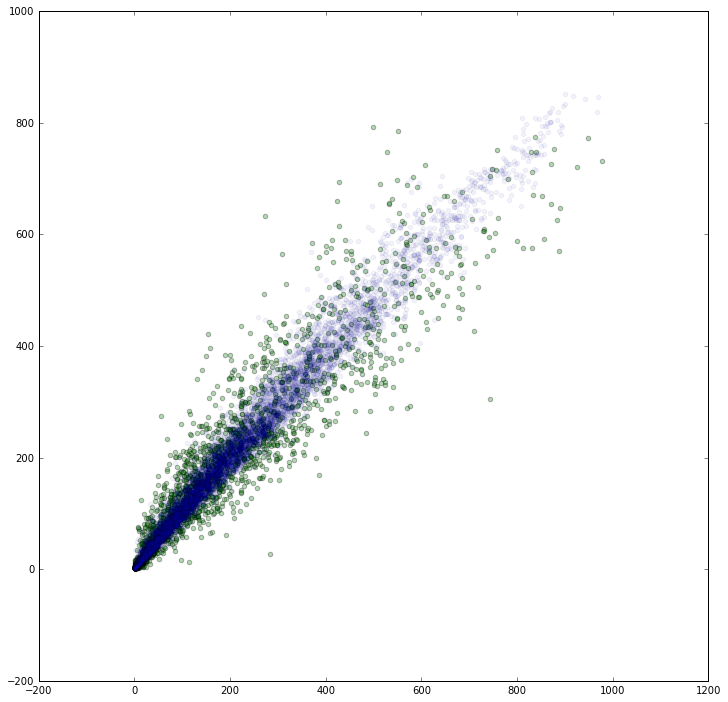

In [667]:
plt.figure(figsize=(12,12))
plt.scatter(y_test, m.predict(X_test), c = 'green', alpha=.3)
plt.scatter(y_train, m.predict(X_train), c = 'blue', alpha = 0.05)

6) Сравните график, полученный на предыдущем шаге с соответсвующим графиком для линейной модели. Какие выводы можно сделать?

Random Forest в данном случае работает гораздо лучше

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.4s finished


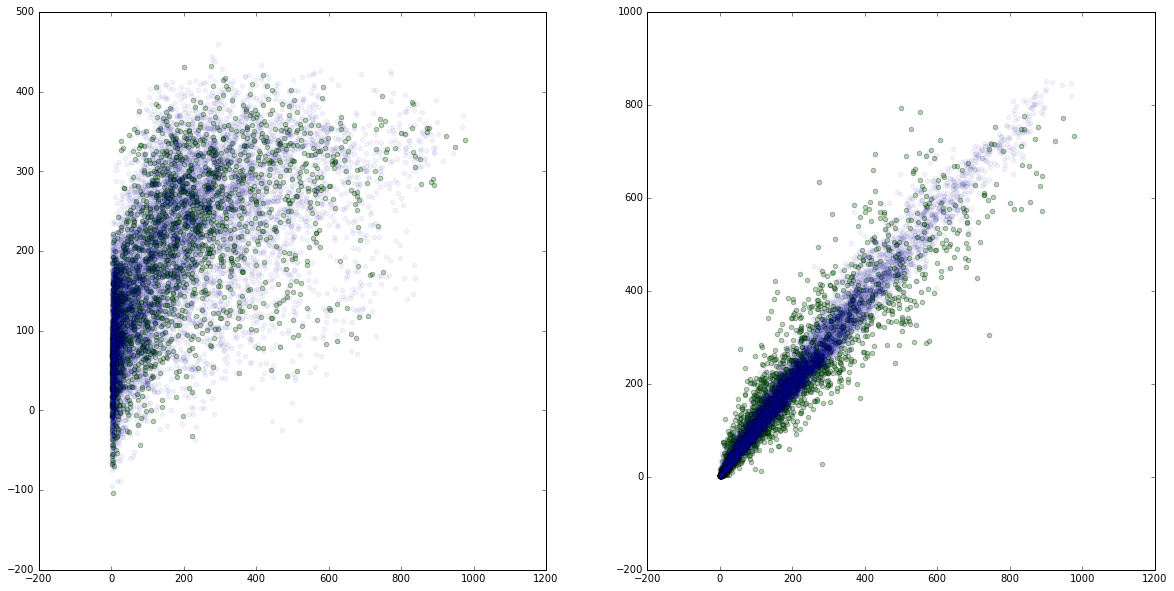

In [666]:
plt.figure(figsize=(20, 10))

plt.subplot(121)
plt.scatter(y_test, gridcv.predict(X_test), c = 'green', alpha=.3)
plt.scatter(y_train, gridcv.predict(X_train), c = 'blue', alpha = 0.05)

plt.subplot(122)
plt.scatter(y_test, m.predict(X_test), c = 'green', alpha=.3)
plt.scatter(y_train, m.predict(X_train), c = 'blue', alpha = 0.05)